In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
%matplotlib inline

# Define the column names for all dataframes
column_names = ['unit_nr', 'time_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]

In [2]:
# Load FD002 Train and Test Data
train_path = os.path.join('..', 'data', 'FD002', 'train_FD002.txt')
train_df = pd.read_csv(train_path, sep='\\s+', header=None, names=column_names)
train_df.dropna(axis=1, how='all', inplace=True)

# Load test data for FD002
test_path = os.path.join('..', 'data', 'FD002', 'test_FD002.txt')
test_df = pd.read_csv(test_path, sep='\\s+', header=None, names=column_names)
test_df.dropna(axis=1, how='all', inplace=True)

print("FD002 Train and Test data loaded successfully")

FD002 Train and Test data loaded successfully



--- Analyzing FD002 Training Data ---
 Sensor Standard Deviation (Train Data FD002)
sensor_16      0.004711
sensor_10      0.127469
sensor_15      0.749335
sensor_11      3.232372
sensor_5       3.613839
sensor_19      5.364067
sensor_6       5.431802
sensor_21      5.921615
sensor_20      9.869331
sensor_1      26.389707
sensor_17     27.754515
sensor_2      37.289399
sensor_14     84.837950
sensor_3     105.946341
sensor_4     119.123428
sensor_13    128.068271
sensor_12    137.659507
sensor_8     145.209816
sensor_18    145.327980
sensor_7     146.005306
sensor_9     335.812013
dtype: float64

Individual Sensor Plots for Engine ID: 1 (Train Data FD002)


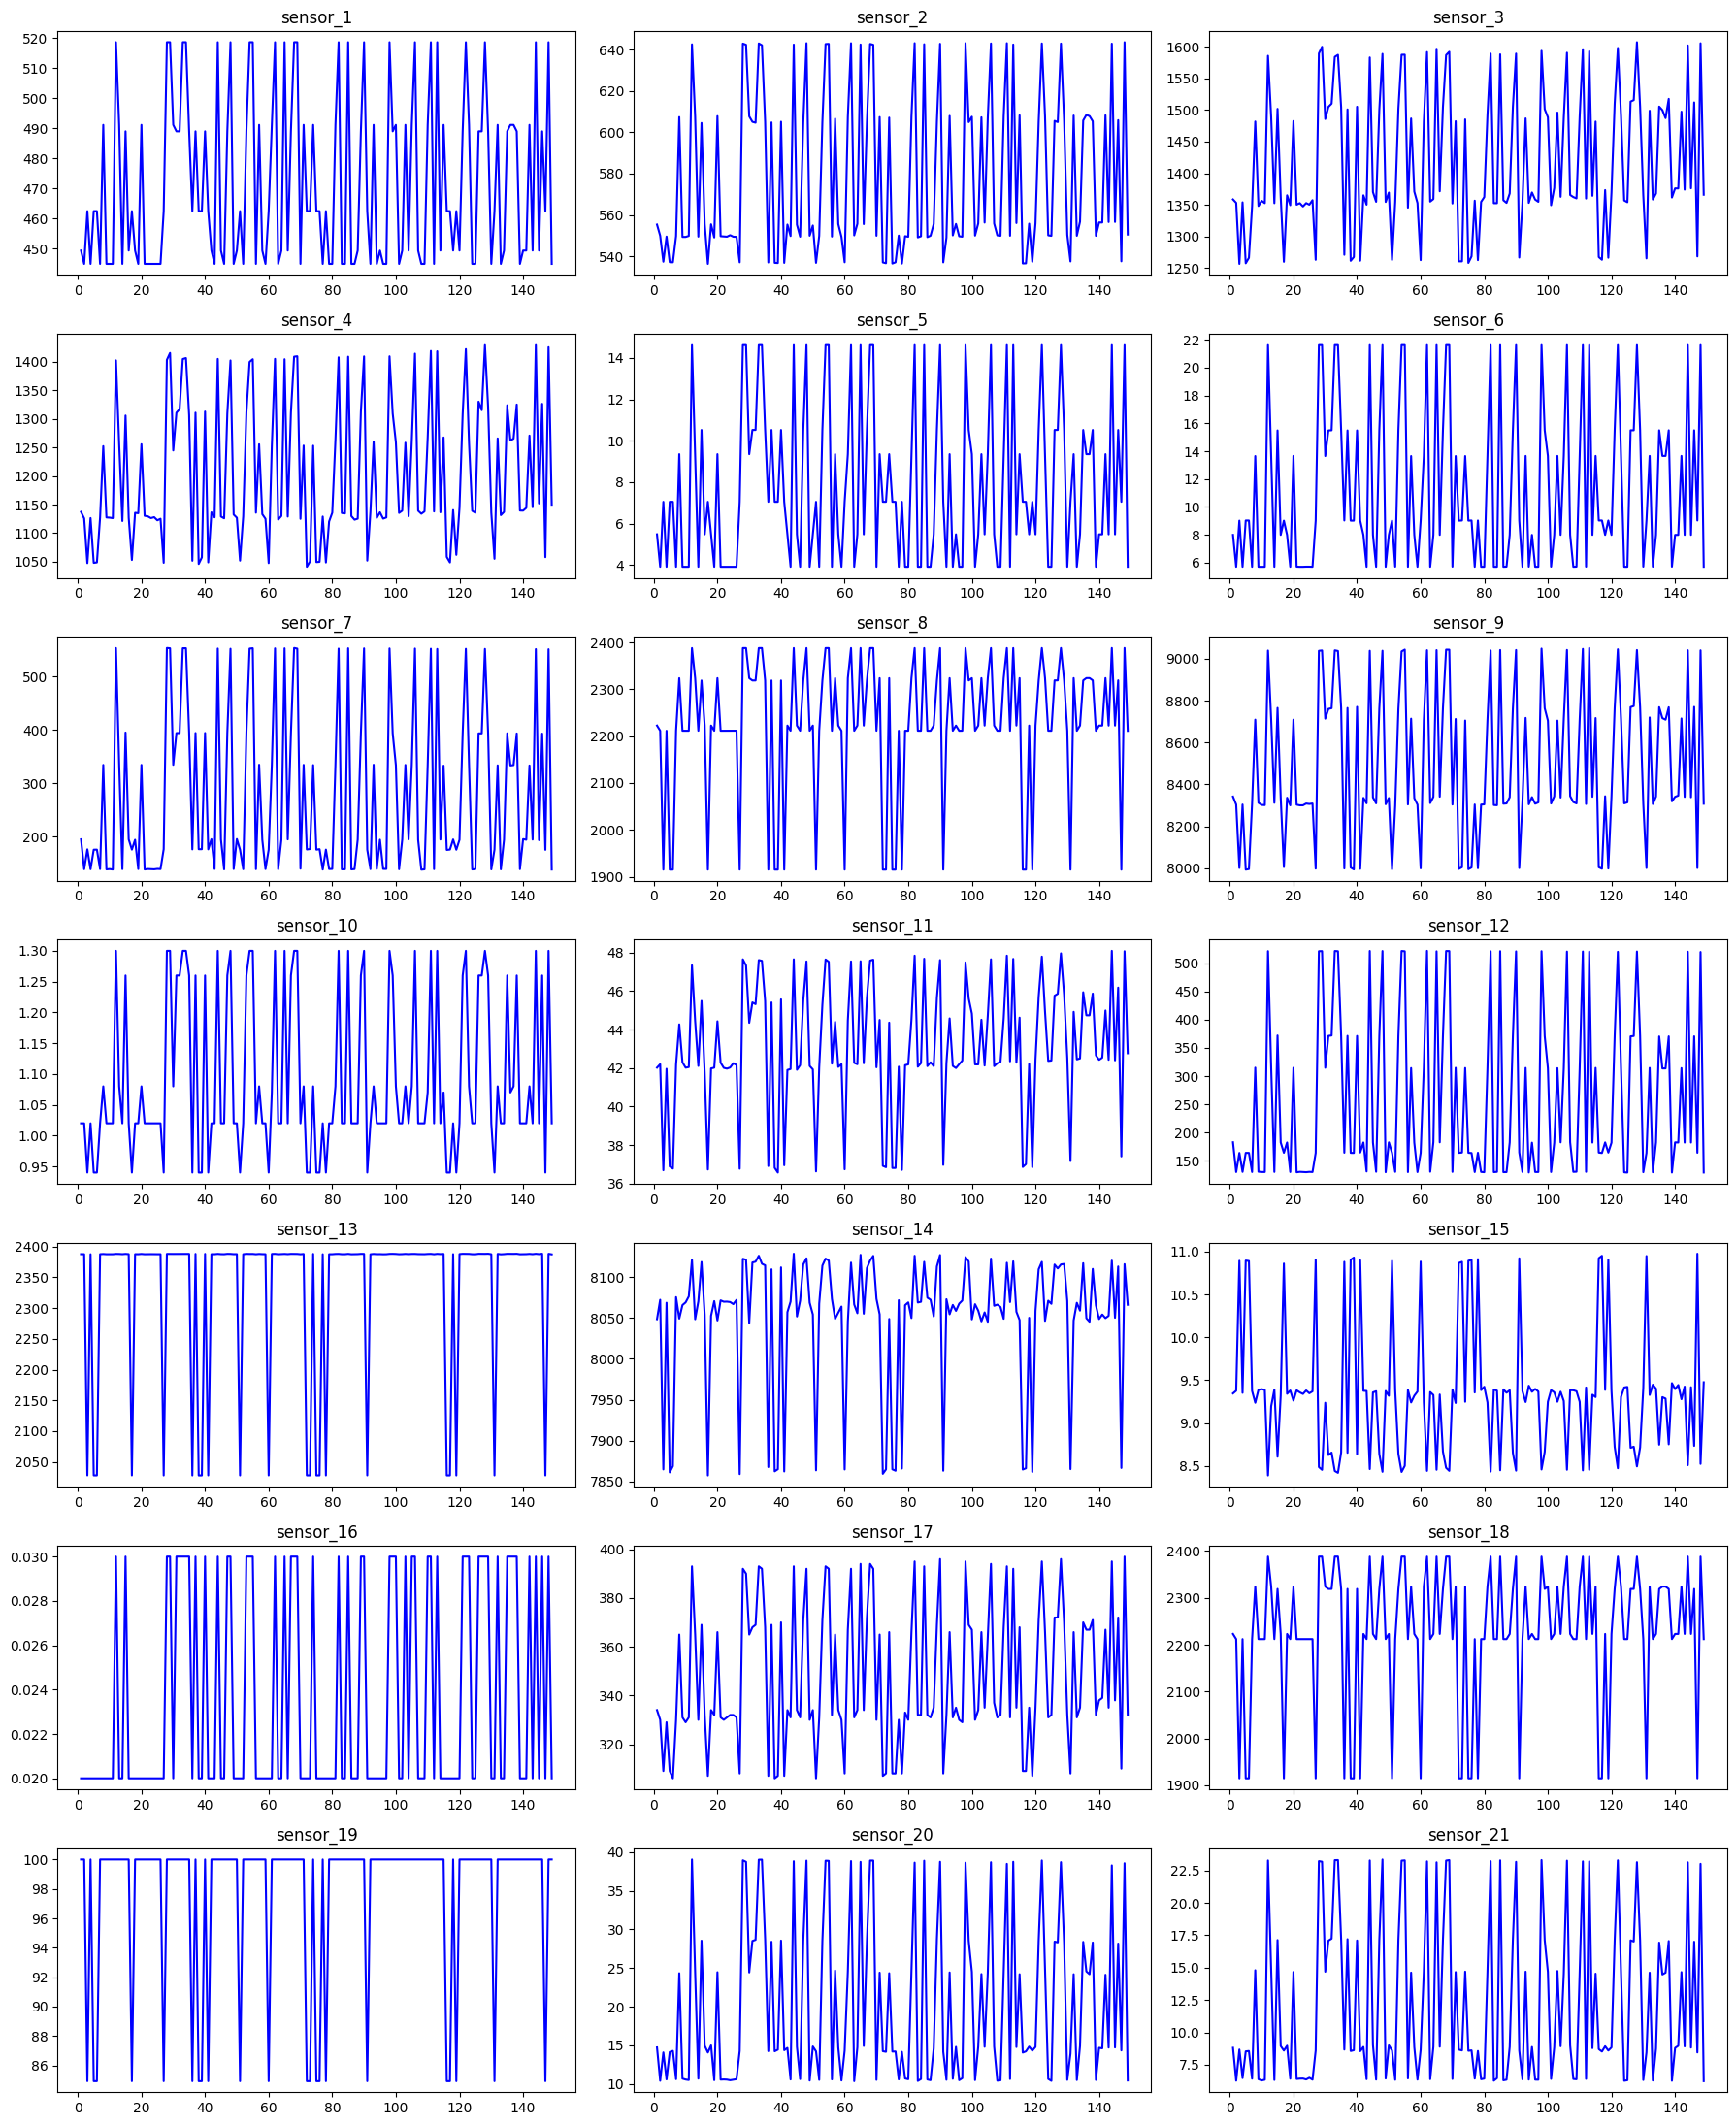

In [3]:
# Exploratory Data Analysis (EDA) on FD002 TRAINING Data

print("\n--- Analyzing FD002 Training Data ---")
# Standard Deviation of Sensors
sensor_columns = [col for col in train_df.columns if col.startswith('sensor_')]
train_std = train_df[sensor_columns].std().sort_values()
print(" Sensor Standard Deviation (Train Data FD002)")
print(train_std)

# Plot Individual Sensor Graphs
print(f"\nIndividual Sensor Plots for Engine ID: 1 (Train Data FD002)")
train_engine_df = train_df[train_df['unit_nr'] == 1]
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(18, 22))
axes = axes.flatten()
for i, sensor in enumerate(sensor_columns):
    ax = axes[i]
    sns.lineplot(data=train_engine_df, x='time_cycles', y=sensor, ax=ax, color='blue')
    ax.set_title(sensor)
    ax.set_xlabel('')
    ax.set_ylabel('')
for j in range(len(sensor_columns), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

In [4]:
# Feature Engineering and Preprocessing for FD002
# Identify and Drop Useless Sensors
useless_sensors = train_std[train_std < 4].index.tolist()
print(f"\nIdentified {len(useless_sensors)} useless sensors for FD002:")
print(useless_sensors)

# Calculate RUL for Training Data
max_cycles = train_df.groupby('unit_nr')['time_cycles'].max()
train_df['RUL'] = train_df.groupby('unit_nr')['time_cycles'].transform(lambda x: x.max() - x)

# Drop Useless Columns
train_df_filtered = train_df.drop(columns=useless_sensors)
test_df_filtered = test_df.drop(columns=useless_sensors)

# Create Final Datasets and Scale
feature_cols = [col for col in train_df_filtered.columns if col in test_df_filtered.columns]
feature_cols = [col for col in feature_cols if col not in ['unit_nr', 'time_cycles', 'RUL']]

X_train = train_df_filtered[feature_cols]
y_train = train_df_filtered['RUL']
X_test = test_df_filtered.groupby('unit_nr').last()[feature_cols] # Select last cycle for prediction

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols)

print("\n--- Final Scaled FD002 Training Data ---")
print(X_train_scaled.head())

print("\n--- Final Scaled FD002 Test Data ---")
print(X_test_scaled.head())



Identified 5 useless sensors for FD002:
['sensor_16', 'sensor_10', 'sensor_15', 'sensor_11', 'sensor_5']

--- Final Scaled FD002 Training Data ---
   op_setting_1  op_setting_2  op_setting_3  sensor_1  sensor_2  sensor_3  \
0      0.833134      0.997625           1.0  0.060269  0.181576  0.311201   
1      0.999767      0.998575           1.0  0.000000  0.131847  0.296600   
2      0.595096      0.738480           0.0  0.238089  0.016332  0.035297   
3      0.999993      0.999525           1.0  0.000000  0.128269  0.298795   
4      0.595137      0.736698           0.0  0.238089  0.014130  0.037871   

   sensor_4  sensor_6  sensor_7  sensor_8  sensor_9  sensor_12  sensor_13  \
0  0.273095  0.144025  0.138036  0.650057  0.289692   0.136817   0.992394   
1  0.245535  0.000000  0.004081  0.626663  0.258841   0.003297   0.992229   
2  0.056997  0.208176  0.092860  0.000718  0.012893   0.089030   0.001157   
3  0.246979  0.000000  0.003962  0.626684  0.258841   0.004058   0.992091   
4  0

In [5]:
# Train and Evaluate Random Forest Model on FD002
# Initialize and Train the Model 
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("\nTraining the model on FD002 data...")
model.fit(X_train_scaled, y_train)
print("Model training complete!")

print("\nMaking predictions on the FD002 test data...")
rul_predictions = model.predict(X_test_scaled)

truth_path = os.path.join('..', 'data', 'FD002', 'RUL_FD002.txt')
truth_df = pd.read_csv(truth_path, header=None)
true_rul = truth_df[0]

rmse = np.sqrt(mean_squared_error(true_rul, rul_predictions))
print(f"\nModel Performance on FD002 (RMSE): {rmse:.2f}")

print("\nFirst 10 Predictions vs. True RUL for FD002:")
for i in range(10):
    print(f"Engine {i+1}: Predicted RUL = {rul_predictions[i]:.0f}, True RUL = {true_rul[i]}")



Training the model on FD002 data...
Model training complete!

Making predictions on the FD002 test data...

Model Performance on FD002 (RMSE): 34.58

First 10 Predictions vs. True RUL for FD002:
Engine 1: Predicted RUL = 20, True RUL = 18
Engine 2: Predicted RUL = 104, True RUL = 79
Engine 3: Predicted RUL = 106, True RUL = 106
Engine 4: Predicted RUL = 84, True RUL = 110
Engine 5: Predicted RUL = 10, True RUL = 15
Engine 6: Predicted RUL = 149, True RUL = 155
Engine 7: Predicted RUL = 18, True RUL = 6
Engine 8: Predicted RUL = 61, True RUL = 90
Engine 9: Predicted RUL = 13, True RUL = 11
Engine 10: Predicted RUL = 98, True RUL = 79


# LSTM

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
%matplotlib inline

In [7]:
DATASET_ID = 'FD002' 
column_names = ['unit_nr', 'time_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]

# Load training data
train_path = os.path.join('..', 'data', DATASET_ID, f'train_{DATASET_ID}.txt')
train_df = pd.read_csv(train_path, sep='\\s+', header=None, names=column_names)
train_df.dropna(axis=1, how='all', inplace=True)

# Load test data
test_path = os.path.join('..', 'data', DATASET_ID, f'test_{DATASET_ID}.txt')
test_df = pd.read_csv(test_path, sep='\\s+', header=None, names=column_names)
test_df.dropna(axis=1, how='all', inplace=True)

print(f" {DATASET_ID} Train and Test data loaded successfully")

 FD002 Train and Test data loaded successfully


In [8]:
# Feature Engineering and Preprocessing
# Identify and Drop Useless Sensors
sensor_columns = [col for col in train_df.columns if 'sensor' in col]
train_std = train_df[sensor_columns].std()
useless_sensors = train_std[train_std < 4].index.tolist()
print(f"\nIdentified {len(useless_sensors)} useless sensors for {DATASET_ID}: {useless_sensors}")

train_df_filtered = train_df.drop(columns=useless_sensors)
test_df_filtered = test_df.drop(columns=useless_sensors)

# Calculate and Clip RUL for Training Data
max_cycles = train_df_filtered.groupby('unit_nr')['time_cycles'].max()
train_df_filtered['RUL'] = train_df_filtered.groupby('unit_nr')['time_cycles'].transform(lambda x: x.max() - x)
train_df_filtered['RUL'] = train_df_filtered['RUL'].clip(upper=125) # Clipping RUL is a key step

# Create Final Datasets and Scale
feature_cols = [col for col in train_df_filtered.columns if col in test_df_filtered.columns]
feature_cols = [col for col in feature_cols if col not in ['unit_nr', 'time_cycles', 'RUL']]

# For LSTM, we need the full timeseries for both train and test
X_train = train_df_filtered[feature_cols]
y_train = train_df_filtered['RUL']
X_test = test_df_filtered[feature_cols]

# Scale features
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Scale target variable (RUL)
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))


Identified 5 useless sensors for FD002: ['sensor_5', 'sensor_10', 'sensor_11', 'sensor_15', 'sensor_16']


In [9]:
# Reshape Data for LSTM

def create_sequences(input_data, target_data, sequence_length):
    X_sequences, y_sequences = [], []
    for i in range(len(input_data) - sequence_length + 1):
        X_sequences.append(input_data[i:(i + sequence_length)])
        y_sequences.append(target_data[i + sequence_length - 1])
    return np.array(X_sequences), np.array(y_sequences)

sequence_length = 50

# Reset indices to align data for filtering
train_df_filtered.reset_index(drop=True, inplace=True)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_cols)

# Create sequences for training data
X_train_reshaped, y_train_reshaped = [], []
for unit_nr in train_df_filtered['unit_nr'].unique():
    unit_data = X_train_scaled_df[train_df_filtered['unit_nr'] == unit_nr]
    unit_target = y_train_scaled[train_df_filtered['unit_nr'] == unit_nr]
    X, y = create_sequences(unit_data.values, unit_target, sequence_length)
    if X.shape[0] > 0:
        X_train_reshaped.append(X)
        y_train_reshaped.append(y)

X_train_final = np.concatenate(X_train_reshaped)
y_train_final = np.concatenate(y_train_reshaped)

# Create a scaled test DataFrame and align its index
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_cols, index=test_df_filtered.index)

# Create sequences for test data (last sequence for each engine)
X_test_reshaped = []
for unit_nr in test_df_filtered['unit_nr'].unique():
    # CORRECTED: Filter the correct scaled test DataFrame
    unit_data = X_test_scaled_df[test_df_filtered['unit_nr'] == unit_nr]
    last_sequence_values = unit_data.values
    if len(last_sequence_values) < sequence_length:
        padding = np.zeros((sequence_length - len(last_sequence_values), last_sequence_values.shape[1]))
        last_sequence = np.concatenate([padding, last_sequence_values])
    else:
        last_sequence = last_sequence_values[-sequence_length:]
    X_test_reshaped.append(last_sequence)

X_test_final = np.array(X_test_reshaped)

print("--- Data Reshaped for LSTM ---")
print("Training data shape:", X_train_final.shape)
print("Test data shape:", X_test_final.shape)


--- Data Reshaped for LSTM ---
Training data shape: (41019, 50, 19)
Test data shape: (259, 50, 19)


c:\Users\Dell\Desktop\Uniconverge\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training the LSTM model on FD002 data...
Epoch 1/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 76s 60ms/step - loss: 0.0908 - val_loss: 0.0614
Epoch 2/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 94s 82ms/step - loss: 0.0482 - val_loss: 0.0328
Epoch 3/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 92s 79ms/step - loss: 0.0373 - val_loss: 0.0213
Epoch 4/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 87s 76ms/step - loss: 0.0316 - val_loss: 0.0224
Epoch 5/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 92s 80ms/step - loss: 0.0282 - val_loss: 0.0234
Epoch 6/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 93s 80ms/step - loss: 0.0259 - val_loss: 0.0230
Epoch 7/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 76s 66ms/step - loss: 0.0266 - val_loss: 0.0179
Epoch 8/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 88s 76ms/step - loss: 0.0240 - val_loss: 0.0293
Epoch 9/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 72s 63ms/step - loss: 0.0236 - val_loss: 0.0226
Epoch 10/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 78s 68ms/step - loss: 0.0229 - val_loss: 0.0200
Epoch 11/20
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 95s 82ms/step 

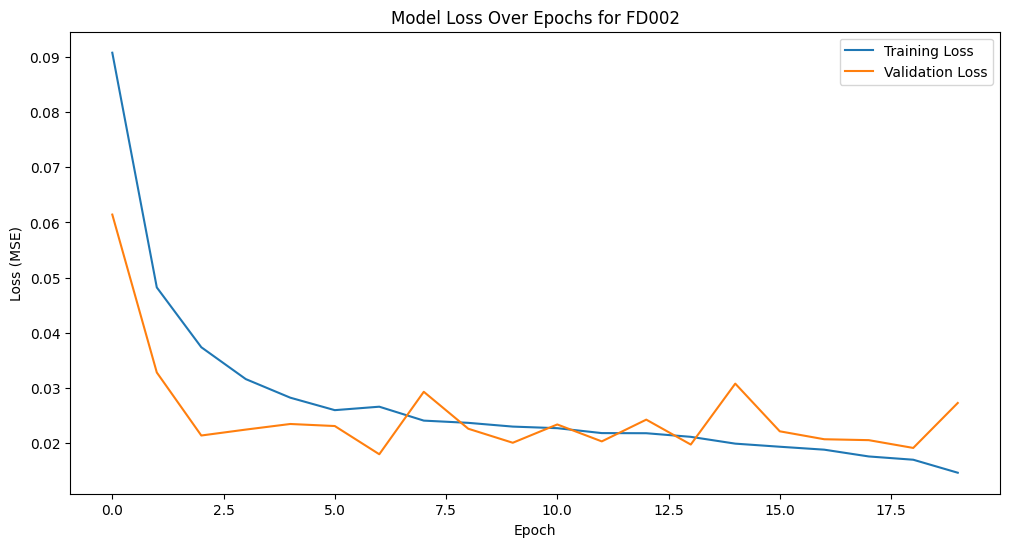

In [10]:
# Build, Train, and Evaluate LSTM Model-
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_final.shape[1], X_train_final.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

print(f"\nTraining the LSTM model on {DATASET_ID} data...")
history = model_lstm.fit(X_train_final, y_train_final, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

rul_predictions_scaled = model_lstm.predict(X_test_final)
rul_predictions_lstm = target_scaler.inverse_transform(rul_predictions_scaled)

truth_path = os.path.join('..', 'data', DATASET_ID, f'RUL_{DATASET_ID}.txt')
truth_df = pd.read_csv(truth_path, header=None)
true_rul = truth_df[0]

rmse_lstm = np.sqrt(mean_squared_error(true_rul, rul_predictions_lstm))
print(f"\nLSTM Model Performance on {DATASET_ID} (RMSE): {rmse_lstm:.2f}")

print("\nFirst 10 Predictions vs. True RUL (LSTM):")
for i in range(10):
    print(f"Engine {i+1}: Predicted RUL = {rul_predictions_lstm[i][0]:.0f}, True RUL = {true_rul[i]}")

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss Over Epochs for {DATASET_ID}')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()